# Bias Correction
This notebook demonstrates z-score bias correction in 4 steps:

1. Look at zonal wind data
2. Filtering the data to the extent of Colorado
3. Aligning the datasets in time
4. A z-score bias correction method

## Set up Workspace
Import all necessary modules and name the variable we will be looking at (zonal wind speed, `uas`).

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import xesmf as xe
from datetime import datetime, timedelta
from ngallery_utils import DATASETS

%matplotlib inline

var = 'uas'

## 1. Look at Data
We have 3 datasets for this correction: a historical model, a future rcp85 model, and measurements.

Ultimately, the historical model will be compared to the measurements to predict an adjustment to the future rcp85 model to be more like future measurements.

In [2]:
hist_file = DATASETS.fetch("uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.nc")
rcp85_file = DATASETS.fetch("uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.nc")
meas_file = DATASETS.fetch("uas.gridMET.NAM-44i.Colorado.nc")

In [3]:
ds_hist = xr.open_dataset(hist_file)
ds_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 8, lon: 16, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
  * lon        (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: CLASS3.5+, 26L, bottom at 60m / lak...
    forcing:                        GHG: CO2,CH4,N2O,CFC11,effective CFC12
    creation_date:                  2012-09-06
    experiment:                     historical
    experiment_id:                  historical
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    frequency:                      day
    institute_id:                   UQAM
    rcm_version_id:                 v1
    project_id:                     CORDEX
    CORDEX_domain:                  NAM-44
    product:                        output
    references:                     http://www.mrcc.uqam.ca
    history:                        Fri Mar 29 14:03:34 2019: ncrcat -O -o /g...
    NCO:                            netCDF Operators version 4.7.4 (http://nc...
    model_id:                       UQAM-CRCM5
    driving_experiment:             CCCma-CanESM2,historical,r1i1p1
    driving_model_id:               CCCma-CanESM2
    history_of_appended_files:      Wed Sep  5 00:03:57 2018: Appended file t...
    tracking_id:                    5718ce6b-2ffb-4efb-9b49-f123e4184106
    nco_openmp_thread_number:       1
    id:                             doi:10.5065/D6SJ1JCH
    title:                          NA-CORDEX Raw NAM-44i CRCM5-UQAM CanESM2 ...
    version:                        1.0

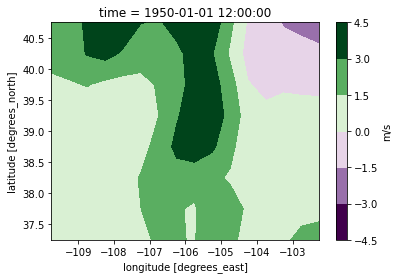

In [4]:
ds_hist[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [5]:
ds_rcp85 = xr.open_dataset(rcp85_file)
ds_rcp85

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 8, lon: 16, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
  * lon        (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: CLASS3.5+, 26L, bottom at 60m / lak...
    forcing:                        GHG: CO2,CH4,N2O,CFC11,effective CFC12
    creation_date:                  2012-09-06
    experiment:                     historical
    experiment_id:                  historical
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    frequency:                      day
    institute_id:                   UQAM
    rcm_version_id:                 v1
    project_id:                     CORDEX
    CORDEX_domain:                  NAM-44
    product:                        output
    references:                     http://www.mrcc.uqam.ca
    history:                        Fri Mar 29 14:03:34 2019: ncrcat -O -o /g...
    NCO:                            netCDF Operators version 4.7.4 (http://nc...
    model_id:                       UQAM-CRCM5
    driving_experiment:             CCCma-CanESM2,historical,r1i1p1
    driving_model_id:               CCCma-CanESM2
    history_of_appended_files:      Wed Sep  5 00:03:57 2018: Appended file t...
    tracking_id:                    5718ce6b-2ffb-4efb-9b49-f123e4184106
    nco_openmp_thread_number:       1
    id:                             doi:10.5065/D6SJ1JCH
    title:                          NA-CORDEX Raw NAM-44i CRCM5-UQAM CanESM2 ...
    version:                        1.0

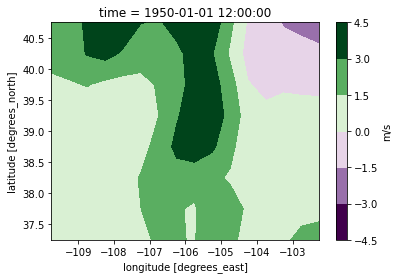

In [6]:
ds_rcp85[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [7]:
ds_meas = xr.open_dataset(meas_file)
ds_meas

<xarray.Dataset>
Dimensions:      (bnds: 2, lat: 8, lon: 16, time: 13880)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T19:00:00 ... 2016-12-31T19:...
  * lon          (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
  * lat          (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
Dimensions without coordinates: bnds
Data variables:
    uas          (time, lat, lon) float32 ...
    time_bnds    (time, bnds) datetime64[ns] ...
    data_status  (time) int8 ...
    lon_bnds     (lon, bnds) float32 ...
    lat_bnds     (lat, bnds) float32 ...
    crs          int32 ...
Attributes:
    author:                    John Abatzoglou - University of Idaho, jabatzo...
    creation_date:             10 March 2016
    Conventions:               CF-1.6
    title:                     gridMET gridded surface meteorological data
    institution:               University of Idaho
    contact:                   John Abatzoglou, jabatzoglou@uidaho.edu
    URL:                       http://www.climatologylab.org/gridmet.html
    references:                Abatzoglou, J.T., 2012, Development of gridded...
    source:                    gridMET combines data from PRISM and NLDAS-2 a...
    acknowledgements:          CF compliance by Seth McGinnis, mcginnis@ucar.edu
    uuid:                      82c7e638-7fb7-4a0d-bcef-c2d18a69f8fa
    history:                   Fri Aug 30 15:00:15 2019: ncrcat -n 38,4,1 uas...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    tracking_id:               da9158a7-73d3-4e74-aeaf-c0f7d0433508
    nco_openmp_thread_number:  1

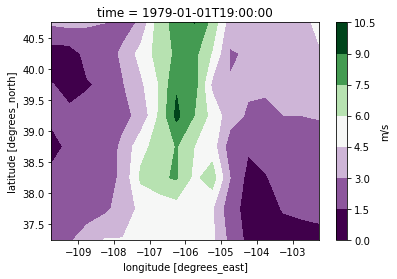

In [8]:
ds_meas[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

## 2. Filter Data
We limit the extent of our data to the state of Colorado simply to speed up our calculations in this example.

In [9]:
wesn = [-110, -108, 39.5, 41.5]
ds_meas_flt = ds_meas.sel(lon = slice(wesn[0], wesn[1]), lat = slice(wesn[2], wesn[3]))
ds_hist_flt = ds_hist.sel(lon = slice(wesn[0], wesn[1]), lat = slice(wesn[2], wesn[3]))
ds_rcp85_flt = ds_rcp85.sel(lon = slice(wesn[0], wesn[1]), lat = slice(wesn[2], wesn[3]))

## 3. Align Time
Our two modeled datasets do not have leap years, where our measured dataset does. 

There are several methods of dealing with leap years that are better for different types of data. For data that is continuous, such as wind speed, we can simply drop all December 31st from leap years (any time there is a 366th day to the year we drop day #366). This method would not be ideal for discontinous data such as precipitation.

In [10]:
ds_meas_noleap = ds_meas_flt.sel(time=~((ds_meas_flt.time.dt.dayofyear == 366) ))

In [11]:
def _cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da#.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

ds_hist_dt = _cfnoleap_to_datetime(ds_hist_flt)   
ds_rcp85_dt = _cfnoleap_to_datetime(ds_rcp85_flt)  

<ipython-input-1-d460699fd441>:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()


We also regroup our models so that the dates of the historical model line up with our historical measurements. 

In [12]:
def _regroup_models_bytime(ds_meas, ds_hist_dt, ds_rcp_dt):
    t0_meas = ds_meas.time[0]
    tn_meas = ds_meas.time[-1]
    t0_fut = tn_meas.values + np.timedelta64(1, 'D')
    
    ds_past = ds_hist_dt.sel(time_dt = slice(t0_meas, tn_meas))
    ds_past = ds_past.swap_dims({'time_dt':'time'})
    
    ds_fut_pt1 = ds_hist_dt.sel(time_dt = slice(t0_fut,None))
    ds_fut = xr.concat([ds_fut_pt1[var], ds_rcp_dt[var]], 'time_dt')
    ds_fut = ds_fut.swap_dims({'time_dt':'time'})
    return ds_past, ds_fut

ds_past, ds_fut = _regroup_models_bytime(ds_meas_noleap, ds_hist_dt, ds_rcp85_dt)

## 4. Z-score Bias Correction

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In essence the technique:

1. Finds the mean  
$$\overline{x} = \sum_{i=0}^N \frac{x_i}{N}$$ 
and standard deviation 
$$\sigma = \sqrt{\frac{\sum_{i=0}^N |x_i - \overline{x}|^2}{N-1}}$$ 
of target (measured) data and training (historical modeled) data. 

2. Compares the difference between the statistical values to produce a shift 
$$shift = \overline{x_{target}} - \overline{x_{training}}$$ 
and scale parameter 
$$scale = \sigma_{target} \div \sigma_{training}$$ 

3. Applies these paramaters to the future model data to be corrected to get a new mean
$$\overline{x_{corrected}} = \overline{x_{future}} + shift$$
and new standard deviation
$$\sigma_{corrected} = \sigma_{future} \times scale$$

4. Calculates the corrected values
$$x_{corrected_{i}} = z_i \times \sigma_{corrected} + \overline{x_{corrected}}$$
from the future model's z-score values
$$z_i = \frac{x_i-\overline{x}}{\sigma}$$

In practice, if the wind was on average 3 m/s faster on the first of July in the models compared to the measurements, we would adjust the modeled data for all July 1sts in the future modeled dataset to be 3 m/s faster. And similarly for scaling the standard deviation

Bias correction methods other than zscore include:

 - scale (for wind speed, wave flux in air)
 - log (for precipitation)
 - range (relative humidity)
 - seth mcginnes's kddm (for any bimodal distributions)

In [13]:
def _reshape(ds, window_width):
    split = lambda g: (g.rename({'time': 'day'})
                       .assign_coords(day=g.time.dt.dayofyear.values))
    ds2 = ds.groupby('time.year').apply(split)
    
    early_Jans = ds2.isel(day = slice(None,window_width//2))
    late_Decs = ds2.isel(day = slice(-window_width//2,None))
    
    ds3 = xr.concat([late_Decs,ds2,early_Jans],dim='day')
    return ds3

def _calc_stats(ds, window_width):
    ds_rsh = _reshape(ds, window_width)
    
    ds_rolled = ds_rsh.rolling(day=window_width, center=True).construct('win_day')
    
    n = window_width//2+1
    ds_mean = ds_rolled.mean(dim=['year','win_day']).isel(day=slice(n,-n))
    ds_std = ds_rolled.std(dim=['year','win_day']).isel(day=slice(n,-n))
    
    ds_avyear = ds_rsh.mean(dim=['year','day'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

window_width=31
meas_mean, meas_std, meas_zscore = _calc_stats(ds_meas_noleap, window_width)
hist_mean, hist_std, hist_zscore = _calc_stats(ds_past, window_width)

In [14]:
def _get_params(meas_mean, meas_std, past_mean, past_std):    
    shift = meas_mean - past_mean
    scale = meas_std / past_std
    return shift, scale

shift, scale = _get_params(meas_mean, meas_std, hist_mean, hist_std)

In [15]:
def _calc_fut_stats(ds_fut, window_width):
    ds_rolled = ds_fut.rolling(time=window_width, center=True).construct('win_day')
    
    ds_mean = ds_rolled.mean(dim=['win_day'])
    ds_std = ds_rolled.std(dim=['win_day'])
    
    ds_avyear = ds_fut.mean(dim=['time'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

fut_mean, fut_std, fut_zscore = _calc_fut_stats(ds_fut, window_width)

In [16]:
fut_mean_bc = fut_mean + shift.uas
fut_std_bc = fut_std * scale

In [17]:
fut_corrected = (fut_zscore * fut_std_bc) + fut_mean_bc

### Visualize the Correction

In [18]:
def gaus(mean, std, doy):
    a = mean.sel(day=doy)
    mu = a.isel(lon = 0, lat = 0)

    b =std.sel(day=doy)
    sigma = b.isel(lon = 0, lat = 0)

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    return x, y

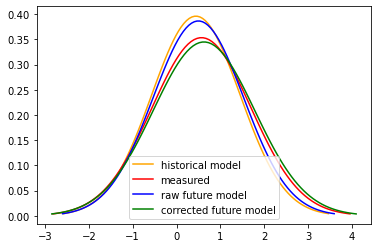

In [19]:
fut_typ_mean, fut_typ_std, fut_typ_zscore = _calc_stats(ds_fut, window_width)
fut_typ_mean_bc = fut_typ_mean + shift
fut_typ_std_bc = fut_typ_std * scale

doy=20
plt.figure()
x,y = gaus(hist_mean[var], hist_std[var], doy)
plt.plot(x, y, 'orange', label = 'historical model')
x,y = gaus(meas_mean[var], meas_std[var], doy)
plt.plot(x, y, 'red', label = 'measured')
x,y = gaus(fut_typ_mean, fut_typ_std, doy)
plt.plot(x, y, 'blue', label = 'raw future model')
x,y = gaus(fut_typ_mean_bc[var], fut_typ_std_bc[var], doy)
plt.plot(x, y, 'green', label = 'corrected future model')
plt.legend()